In [1]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from PIL import Image
import albumentations
import albumentations.pytorch 
import cv2
import torch.nn as nn
import copy
from barbar import Bar

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark=True
    torch.backends.cudnn.deterministic=False  

In [4]:
#train_pure = '/kaggle/input/breast-256/gcn_256/Train_gcn/*'
val_pure =  'gcn_256/Val_gcn/*'

In [5]:
import glob
#train_files = glob.glob(train_pure)
val_files = glob.glob(val_pure)
len(val_files)#6229

1557

In [6]:
val_files[0]

'gcn_256/Val_gcn/SOB_M_PC-15-190EF-200-001.png'

In [7]:
x=val_files[0]
x.split('_')
x.split('-')[-2]

'200'

In [8]:
val_B=[]
val_40B=[]
val_100B=[]
val_200B=[]
val_400B=[]
for i in val_files:
    parts=i.split('_')
    parts1=i.split('-')
    if (parts[-2])== "B":
        val_B.append(i)
        
        if (parts1[-2])== "40":
            val_40B.append(i)
        elif (parts1[-2])== "100":
            val_100B.append(i)
        elif (parts1[-2])== "200":
            val_200B.append(i)
        elif (parts1[-2])== "400":
            val_400B.append(i)
print(len(val_40B),len(val_100B),len(val_200B),len(val_400B))
print(len(val_B))

125 131 112 116
484


In [9]:
import albumentations
import albumentations.pytorch 
class My_data(Dataset):
    def __init__(self, data, transforms=None):
        self.image_list = data
        self.data_len = len(self.image_list)
        self.transforms = transforms
        self.eicls = ["A", "F", "TA", "PT", "DC", "LC", "MC", "PC"]
        
    def __getitem__(self, index):
        current_image_path = self.image_list[index]
        im_as_im = cv2.imread(current_image_path)
        im_as_im = cv2.cvtColor(im_as_im, cv2.COLOR_BGR2RGB)

        # Perform label encoding for multi-label classification
        parts = current_image_path.split('_')[-1].split('-')
        if parts[2]=="13412":
            labels =[0,0,0,0,1,1,0,0]
        else:
            labels = [int(label == parts[0]) for label in self.eicls]       
        labels = torch.tensor(labels)

        if self.transforms is not None:
            augmented = self.transforms(image=im_as_im)
            im_as_im = augmented['image']

        return (im_as_im, labels)

    def __len__(self):
        return self.data_len             
 
   

In [10]:
transform = {
    'train': albumentations.Compose([
    albumentations.Resize(256, 256),     
    albumentations.OneOf([
                          albumentations.HorizontalFlip(),
                          albumentations.RandomRotate90(),
                          albumentations.VerticalFlip(),
                          albumentations.GaussianBlur(),
                          albumentations.NoOp()
    ], p=0.2),
    albumentations.Normalize(mean=(0.787, 0.625, 0.765),
                       std=(0.105, 0.138, 0.089), p=1),
    albumentations.pytorch.transforms.ToTensorV2()]),
    
    'valid': albumentations.Compose([
    albumentations.Resize(256, 256),     
    albumentations.Normalize(mean=(0.786, 0.623, 0.766),
                       std=(0.105, 0.138, 0.089), p=1),
    albumentations.pytorch.transforms.ToTensorV2()]),}
    

valid=My_data(val,transforms=transform['valid'])
valid_dataloader=  torch.utils.data.DataLoader(dataset=valid,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [11]:
valid = My_data(val_B,transforms=transform['valid'])
valid_B=  torch.utils.data.DataLoader(dataset=valid,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [12]:
vali_40B=My_data(val_40B,transforms=transform['valid'])
valid_40B=  torch.utils.data.DataLoader(dataset=vali_40B,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [13]:
vali_100B=My_data(val_100B,transforms=transform['valid'])
valid_100B=  torch.utils.data.DataLoader(dataset=vali_100B,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [14]:
vali_200B = My_data(val_200B,transforms=transform['valid'])
valid_200B=  torch.utils.data.DataLoader(dataset=vali_200B,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [15]:
vali_400B = My_data(val_400B,transforms=transform['valid'])
valid_400B=  torch.utils.data.DataLoader(dataset=vali_400B,batch_size=1,shuffle=False,num_workers=4,
                                               pin_memory=True )  

In [16]:
import torch
class_samples = [367, 803, 456, 370, 2763, 492, 629, 449]  # Number of samples in each class
total_samples = sum(class_samples)
samples=total_samples/len(class_samples)
class_weights = [samples / (s + 1e-8) for s in class_samples]
class_weights = torch.tensor(class_weights)
print(class_weights)

tensor([2.1557, 0.9852, 1.7349, 2.1382, 0.2863, 1.6080, 1.2578, 1.7620])


In [17]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, class_weights=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.class_weights = class_weights

    def forward(self, logits, labels):
        probs = torch.sigmoid(logits)
        ce_loss = nn.BCELoss()(probs, labels)
        weight = (1 - probs).pow(self.gamma)
        loss = ce_loss  # Initialize loss with cross-entropy loss
        if self.class_weights is not None:
            weight = weight * self.class_weights
            loss = loss * weight
        return loss

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
from timm.models import create_model
from timm.data import create_transform
from sklearn.metrics import accuracy_score

# Define device
# Define Swin Transformer v2 model
"""model_name = 'swin_base_patch4_window7_224'
num_classes = 8
model = create_model(
    model_name=model_name,
    pretrained=True,
    num_classes=num_classes,
    drop_rate=0.5,
    drop_path_rate=0.2,
    checkpoint_path=None
)"""
model = timm.create_model(
    'swinv2_tiny_window8_256.ms_in1k',
    pretrained=False,
    features_only=False,
    num_classes = 8,
    drop_path_rate=0.2
)
class_weights=class_weights.to(device)
criterion = FocalLoss(class_weights)
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
checkpoint1 = torch.load('ac98data/eft_tiny.pth')
model.load_state_dict(checkpoint1['model_state_dict'])
model = model.to(device)

/home/kb/anaconda3/envs/pytorch-gpu/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
#define the function that take model and etc.. and compute val loss and val_accuracy and ypred and y true
def validate(model, dataloader, optimizer, criterion):
    #print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.float()
            labels = labels.to(device)
            outputs = model(inputs)
            thresholds = [0.5, 0.5, 0.5,0.5,0.5,0.5,0.5,0.5]
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()*inputs.size(0)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
           
            y_pred.extend(preds)
            y_true.extend(labels)
            
            #print(preds,labels)
            for i, threshold in enumerate(thresholds):
                preds[:, i] = (probs[:, i] >= threshold).float()
            val_running_correct += (preds == labels).all(dim=1).float().sum()
            
        
    val_loss = val_running_loss/len(dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(dataloader.dataset)        
    return val_loss, val_accuracy,y_pred,y_true

In [20]:
#Four MI  for Benign
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_B, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predB= [arr[0:4] for arr in y_pred]
y_trueB= [arr[0:4] for arr in y_true]
accuracy =accuracy_score (y_trueB, y_predB)       
recall=recall_score(y_trueB, y_predB, average='weighted')
f1=f1_score(y_trueB, y_predB, average='weighted')
precision=precision_score(y_trueB, y_predB, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9896694214876033 recall = 0.9917355371900827 F1-measure = 0.9917127061126808 precision = 0.991889294637709


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_trueB ,y_predB, digits=3,zero_division=1))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        77
           1      0.981     1.000     0.991       211
           2      1.000     0.991     0.996       113
           3      1.000     0.964     0.982        83

   micro avg      0.992     0.992     0.992       484
   macro avg      0.995     0.989     0.992       484
weighted avg      0.992     0.992     0.992       484
 samples avg      0.993     0.992     0.991       484



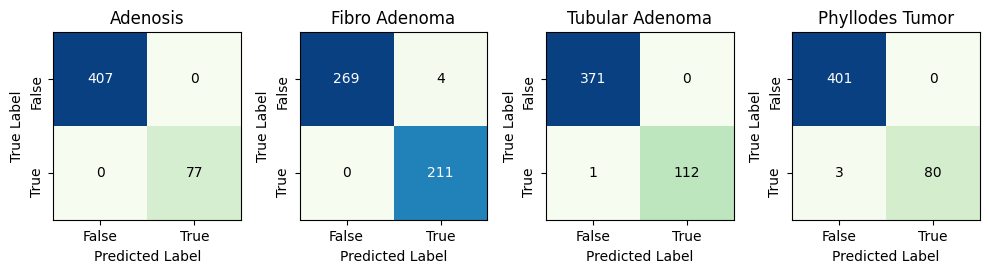

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

# Create the confusion matrices
confusion_mat = multilabel_confusion_matrix(y_trueB, y_predB)

# Create a 2x4 grid for subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

# Class names
class_names = ["Adenosis", "Fibro Adenoma", "Tubular Adenoma", "Phyllodes Tumor"]

# Iterate over each confusion matrix and plot in the corresponding subplot
for i, ax in enumerate(axes.flat):
    # Check if there are more confusion matrices than the grid size
    if i < len(confusion_mat):
        im = ax.imshow(confusion_mat[i], interpolation='nearest', cmap=plt.cm.GnBu)
        ax.set_title(f"{class_names[i]}")
        ax.set_xlabel('Predicted Label')
        ax.set_ylabel('True Label')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['False', 'True'])
        ax.set_yticklabels(['False', 'True'],rotation=90)

        # Add count values in each cell
        thresh = confusion_mat[i].max() / 2.
        for j in range(confusion_mat[i].shape[0]):
            for k in range(confusion_mat[i].shape[1]):
                ax.text(k, j, format(confusion_mat[i, j, k], 'd'),
                         ha="center", va="center",
                         color="white" if confusion_mat[i, j, k] > thresh else "black")
    else:
        # If there are fewer confusion matrices than the grid size, remove the empty subplot
        fig.delaxes(ax)

plt.tight_layout()
plt.savefig('integrated_data/figs/IntBENcon.eps', format='eps')
plt.show()

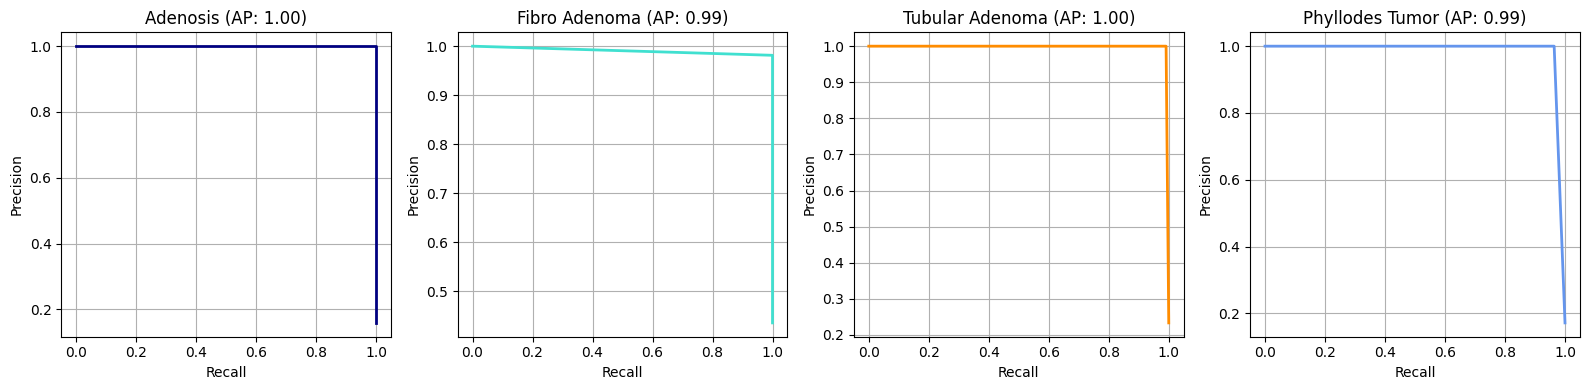

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve,auc
from itertools import cycle

# Assuming you have the true labels and predicted probabilities as lists of lists
# Convert lists to NumPy arrays

class_names = ["Adenosis", "Fibro Adenoma", "Tubular Adenoma", "Phyllodes Tumor"]
# Calculate precision and recall for each label
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve([label[i] for label in y_trueB], [label[i] for label in y_predB])
    average_precision[i] = auc(recall[i], precision[i])
# Plot precision-recall curves in a 2x4 grid
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])

for i, ax in enumerate(axes.flat):
    if i < 8:
        ax.plot(recall[i], precision[i], color=next(colors), lw=2)
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")       
        ax.set_title("{} (AP: {:.2f})".format(class_names[i], average_precision[i]))
        ax.grid(True)  # Add gridlines to the subplot
plt.tight_layout()
plt.savefig('integrated_data/figs/pr_B.eps', format='eps')
plt.show()

In [24]:
#Four MD 40x for benign
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_40B, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predB40= [arr[0:4] for arr in y_pred]
y_trueB40= [arr[0:4] for arr in y_true]
accuracy =accuracy_score (y_trueB40, y_predB40)       
recall=recall_score(y_trueB40, y_predB40, average='weighted')
f1=f1_score(y_trueB40, y_predB40, average='weighted')
precision=precision_score(y_trueB40, y_predB40, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 1.0 recall = 1.0 F1-measure = 1.0 precision = 1.0


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_trueB40, y_predB40, digits=3,zero_division=1))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        20
           1      1.000     1.000     1.000        59
           2      1.000     1.000     1.000        29
           3      1.000     1.000     1.000        17

   micro avg      1.000     1.000     1.000       125
   macro avg      1.000     1.000     1.000       125
weighted avg      1.000     1.000     1.000       125
 samples avg      1.000     1.000     1.000       125



In [26]:
#Four MD 100x for BENIGN
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_100B, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predB100= [arr[0:4] for arr in y_pred]
y_trueB100= [arr[0:4] for arr in y_true]
accuracy =accuracy_score (y_trueB100, y_predB100)       
recall=recall_score(y_trueB100, y_predB100, average='weighted')
f1=f1_score(y_trueB100, y_predB100, average='weighted')
precision=precision_score(y_trueB100, y_predB100, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9923664122137404 recall = 0.9923664122137404 F1-measure = 0.9960901135728916 precision = 1.0


In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_trueB100, y_predB100, digits=3,zero_division=1))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        22
           1      1.000     1.000     1.000        61
           2      1.000     1.000     1.000        27
           3      1.000     0.952     0.976        21

   micro avg      1.000     0.992     0.996       131
   macro avg      1.000     0.988     0.994       131
weighted avg      1.000     0.992     0.996       131
 samples avg      1.000     0.992     0.992       131



In [28]:
#Four MD 200x for BENIGN
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_200B, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predB200= [arr[0:4] for arr in y_pred]
y_trueB200= [arr[0:4] for arr in y_true]
accuracy =accuracy_score (y_trueB200, y_predB200)       
recall=recall_score(y_trueB200, y_predB200, average='weighted')
f1=f1_score(y_trueB200, y_predB200, average='weighted')
precision=precision_score(y_trueB200, y_predB200, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9821428571428571 recall = 0.9821428571428571 F1-measure = 0.9819487577639752 precision = 0.98290273556231


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_trueB200, y_predB200, digits=3 ,zero_division=1))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        16
           1      0.957     1.000     0.978        45
           2      1.000     1.000     1.000        27
           3      1.000     0.917     0.957        24

   micro avg      0.982     0.982     0.982       112
   macro avg      0.989     0.979     0.984       112
weighted avg      0.983     0.982     0.982       112
 samples avg      0.982     0.982     0.982       112



In [30]:
#Four MD 400x for malignant
from sklearn.metrics import confusion_matrix,recall_score,f1_score,precision_score,matthews_corrcoef,accuracy_score
import seaborn as sn
import pandas as pd
import numpy as np
val_loss, val_accuracy,y_pred,y_true = validate(model,valid_400B, optimizer, criterion)
#converting cuda list to cpu list and subsequently converting numpy
#to work with sklearn.matrics
y_pred = [tensor.cpu().numpy() for tensor in y_pred]
y_true=  [tensor.cpu().numpy() for tensor in y_true]
y_predB400= [arr[0:4] for arr in y_pred]
y_trueB400= [arr[0:4] for arr in y_true]
accuracy =accuracy_score (y_trueB400, y_predB400)       
recall=recall_score(y_trueB400, y_predB400, average='weighted')
f1=f1_score(y_trueB400, y_predB400, average='weighted')
precision=precision_score(y_trueB400, y_predB400, labels=None, pos_label=1, average='weighted')
#mcc=matthews_corrcoef(y_true1, y_pred1, sample_weight=None)  
print("accuracy =",accuracy ,"recall =",recall,"F1-measure =",f1,"precision =" ,precision)

accuracy = 0.9827586206896551 recall = 0.9913793103448276 F1-measure = 0.9871793277540819 precision = 0.9834770114942529


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_trueB400, y_predB400, digits=3,zero_division=1))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        19
           1      0.958     1.000     0.979        46
           2      1.000     0.967     0.983        30
           3      1.000     1.000     1.000        21

   micro avg      0.983     0.991     0.987       116
   macro avg      0.990     0.992     0.990       116
weighted avg      0.983     0.991     0.987       116
 samples avg      0.987     0.991     0.989       116



In [ ]:
98.21 & 98.21 & 98.19 & 98.29

In [ ]:
98.28 & 99.14 & 98.72 & 98.35